In [4]:
from slvsh_tr import load_examples

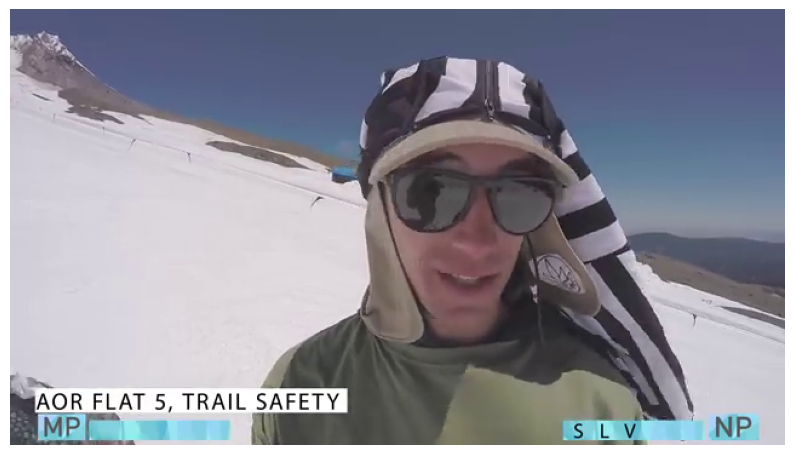

In [5]:
import cv2
import matplotlib.pyplot as plt

examples = load_examples()
image = examples[150].get_image()
# Convert BGR to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.imshow(image_rgb)
plt.show()

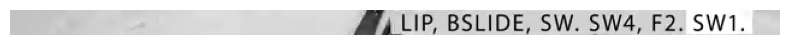

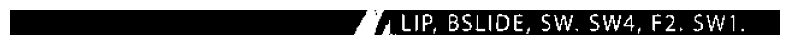

'A, LIP, BSLIDE, SW. SW4, F2. SW1.'

In [33]:
from slvsh_tr import Recognizer
import pytesseract

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(image, 'gray')
    plt.show()

class TesseractRecognier(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), :]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, thresh_image = cv2.threshold(gray_frame, 100, 255, cv2.THRESH_BINARY_INV)

        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'
        extracted_text = pytesseract.image_to_string(thresh_image, config=config).strip()

        if self.debug:
            display_image(gray_frame)
            display_image(thresh_image)

        return extracted_text

model = TesseractRecognier(debug=True)
model.infer(examples[176].get_image())

画像の上下を大きめにとる


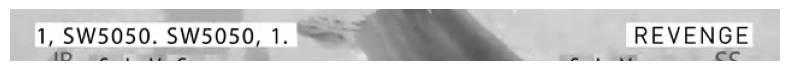

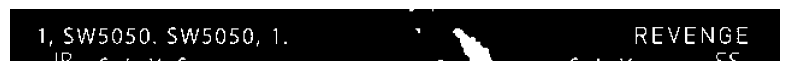

'SEL EO 7 . BS'

In [47]:
from slvsh_tr import Recognizer
import pytesseract

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(image, 'gray')
    plt.show()

class TesseractRecognier(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.84):int(height * 0.96), :]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, thresh_image = cv2.threshold(gray_frame, 100, 255, cv2.THRESH_BINARY_INV)

        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'
        extracted_text = pytesseract.image_to_string(thresh_image, config=config).strip()

        if self.debug:
            display_image(gray_frame)
            display_image(thresh_image)

        return extracted_text

model = TesseractRecognier(debug=True)
model.infer(examples[40].get_image())

評価関数を定義

In [9]:
from slvsh_tr import eval
import pandas as pd

model = TesseractRecognier()
result = eval(model)

# 評価結果をDataFrameに変換
df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples: 100%|██████████| 178/178 [01:43<00:00,  1.73it/s]


precision    0.267845
recall       0.399276
f1           0.243097
dtype: float64

領域を広く取った場合は精度が下がった



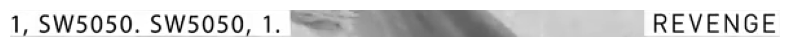

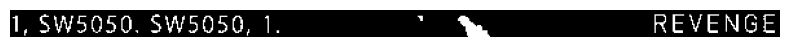

'1, SW5050. SW505G, 1. 7 REVENGE'

In [48]:
from slvsh_tr import Recognizer
import pytesseract

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(image, 'gray')
    plt.show()

class TesseractRecognier(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, thresh_image = cv2.threshold(gray_frame, 100, 255, cv2.THRESH_BINARY_INV)

        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'
        extracted_text = pytesseract.image_to_string(thresh_image, config=config).strip()

        if self.debug:
            display_image(gray_frame)
            display_image(thresh_image)

        return extracted_text

model = TesseractRecognier(debug=True)
model.infer(examples[40].get_image())

In [49]:
model = TesseractRecognier()
result = eval(model)

df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples:   0%|          | 0/178 [00:00<?, ?it/s]

Evaluating examples: 100%|██████████| 178/178 [02:43<00:00,  1.09it/s]


precision    0.575940
recall       0.795950
f1           0.590231
dtype: float64

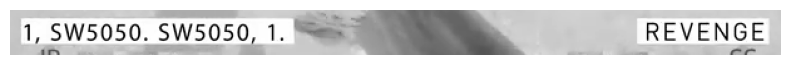

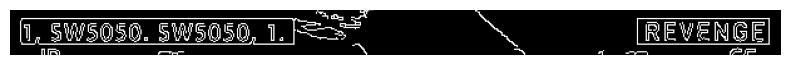

テキスト領域: (8, 7, 260, 21)


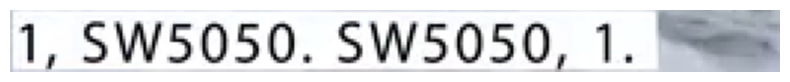

'1, SW5050. SW5050, 1.'

In [55]:
from slvsh_tr import Recognizer
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectRecognier(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(edges)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.1 and h > height * 0.05:
                text_regions.append((x, y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2] * r[3])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.85):int(height * 0.95), int(width * 0.02):int(width * 0.98)]
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            target_image = roi
            extracted_text = pytesseract.image_to_string(target_image, config=config).strip()
        else:
            x, y, w, h = text_region
            target_image = roi[y:y+h, x:x+w]
            extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectRecognier(debug=True)
model.infer(examples[40].get_image())

いい感じなのでほぞん


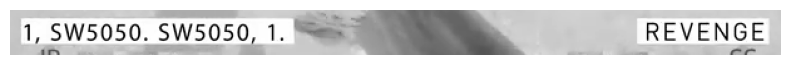

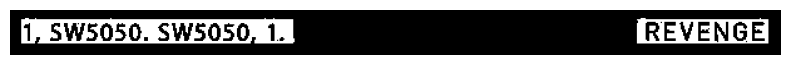

テキスト領域: (9, 7, 218, 20)


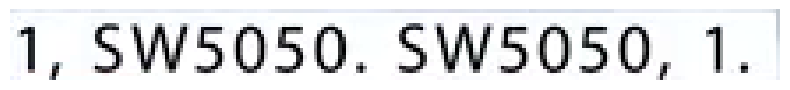

'1, SW5050. SW5050. 1.'

In [58]:
from slvsh_tr import Recognizer
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRect2Recognier(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.1 and h > height * 0.05:
                text_regions.append((x, y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2] * r[3])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.85):int(height * 0.95), int(width * 0.02):int(width * 0.98)]
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            target_image = roi
            extracted_text = pytesseract.image_to_string(target_image, config=config).strip()
        else:
            x, y, w, h = text_region
            target_image = roi[y:y+h, x:x+w]
            extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRect2Recognier(debug=True)
model.infer(examples[40].get_image())

In [59]:
model = TesseractFindRect2Recognier()
result = eval(model)

df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples: 100%|██████████| 178/178 [01:26<00:00,  2.05it/s]


precision    0.694894
recall       0.814147
f1           0.655007
dtype: float64

In [60]:
df.sort_values(by='precision').head(20)

,prediction,expected,precision,recall,f1
0,,REVENGE UN SW5 NOSE.,0.0,0.0,0.0
143,"27, 6",,0.0,1.0,0.0
127,4,,0.0,1.0,0.0
125,AKPIAIO LARKCRK,,0.0,1.0,0.0
45,UW,,0.0,1.0,0.0
122,,"SWR TAILS 2. OW BSLIDE, B2.",0.0,0.0,0.0
48,S,,0.0,1.0,0.0
121,MS UTREE TAPS,TREE TAP,0.0,0.0,0.0
54,4,,0.0,1.0,0.0
118,",",,0.0,1.0,0.0


赤と緑の領域を白くする

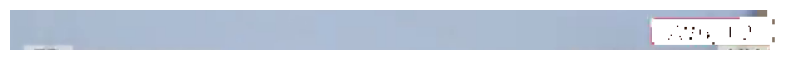

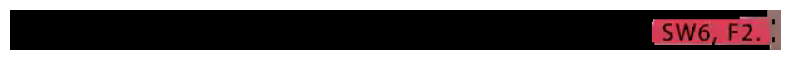

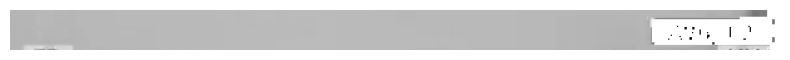

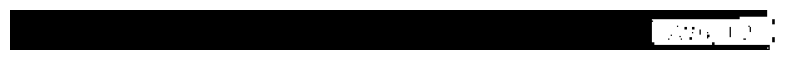

テキスト領域: (512, 0, 103, 32)


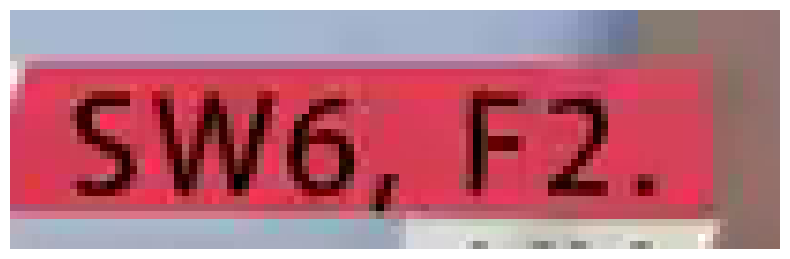

'WO, F2.'

In [39]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitningRecognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_kinjiro_color(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）
        lower_red1 = np.array([0, 40, 40])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 40, 40])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_red1, mask_red2))
        
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.1 and h > height * 0.05:
                text_regions.append((x, y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2] * r[3])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.85):int(height * 0.94), int(width * 0.02):int(width * 0.98)]
        
        original_roi = roi.copy()
        roi = self.whiten_kinjiro_color(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            target_image = original_roi
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitningRecognizer(debug=True)
model.infer(examples[72].get_image())

In [40]:
from slvsh_tr import eval
import pandas as pd

model = TesseractFindRectWhitningRecognizer()
result = eval(model)

df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples: 100%|██████████| 178/178 [01:14<00:00,  2.39it/s]


precision    0.778814
recall       0.905118
f1           0.747839
dtype: float64

In [31]:
df.sort_values(by='precision').head(20)

,prediction,expected,precision,recall,f1
161,TR,,0.0,1.0,0.0
160,,"2, SW.",0.0,0.0,0.0
74,"CC , EV",,0.0,1.0,0.0
73,MY,,0.0,1.0,0.0
23,SE EE,,0.0,1.0,0.0
72,,"SW6, F2.",0.0,0.0,0.0
71,,"TT, BIO 5.",0.0,0.0,0.0
131,4,,0.0,1.0,0.0
58,4,,0.0,1.0,0.0
29,A,BACKSLIDE,0.0,0.0,0.0


In [35]:
df.sort_values(by='recall').head(20)

,prediction,expected,precision,recall,f1
160,,"2, SW.",0.000000,0.000000,0.000000
79,NBS ..,NB5,0.000000,0.000000,0.000000
72,,"SW6, F2.",0.000000,0.000000,0.000000
71,,"TT, BIO 5.",0.000000,0.000000,0.000000
49,,"2, B2.",0.000000,0.000000,0.000000
29,A,BACKSLIDE,0.000000,0.000000,0.000000
90,50.,"BLENDER SW2, B2. 5050.",0.500000,0.142857,0.222222
3,NOLLIE,NOLLIE. TAIL PRESS THROUGH DFD,1.000000,0.166667,0.285714
158,.,"UN 1, PRETZ 1.",1.000000,0.166667,0.285714
99,CORK,CORK 5.,1.000000,0.333333,0.500000


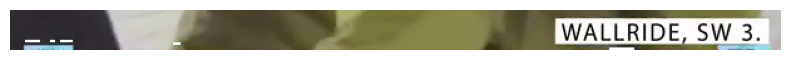

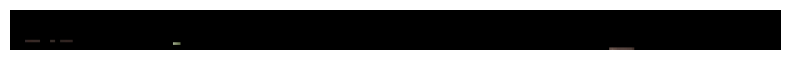

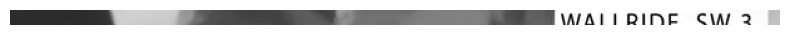

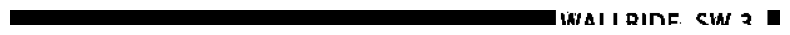

テキスト領域: (436, 8, 169, 12)


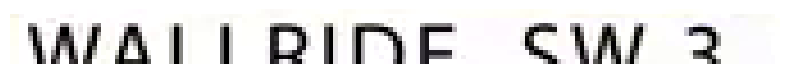

'NAJATIDINC C1A 2.'

In [48]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitningRecognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_kinjiro_color(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）
        lower_red1 = np.array([0, 40, 40])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 40, 40])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_red1, mask_red2))
        
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        # 上辺と底辺の位置を指定
        top_y = 8
        bottom_y = 20
        
        # 指定された領域のみを処理
        roi = image[top_y:bottom_y, :]
        
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.1 and h > (bottom_y - top_y) * 0.9:
                text_regions.append((x, y + top_y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2] * r[3])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.85):int(height * 0.94), int(width * 0.02):int(width * 0.98)]
        
        original_roi = roi.copy()
        roi = self.whiten_kinjiro_color(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            target_image = original_roi
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitningRecognizer(debug=True)
model.infer(examples[4].get_image())

ここで一度上下カットを戻してみる


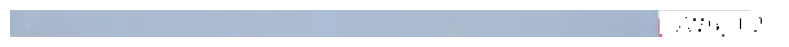

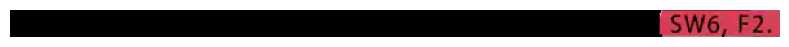

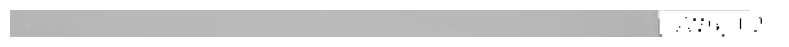

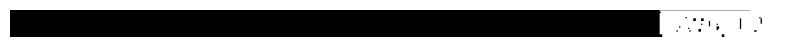

テキスト領域: (502, 0, 93, 21)


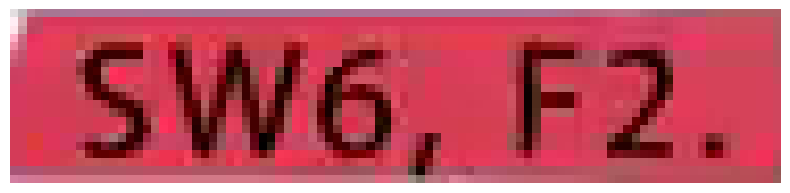

'SW6, F2.'

In [52]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitningRecognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_kinjiro_color(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）
        lower_red1 = np.array([0, 40, 40])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 40, 40])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_red1, mask_red2))
        
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.1 and h > height * 0.05:
                text_regions.append((x, y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2] * r[3])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_kinjiro_color(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            target_image = original_roi
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitningRecognizer(debug=True)
model.infer(examples[72].get_image())

In [53]:
model = TesseractFindRectWhitningRecognizer()
result = eval(model)

df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples: 100%|██████████| 178/178 [01:38<00:00,  1.81it/s]


precision    0.744961
recall       0.938532
f1           0.732063
dtype: float64